In [62]:
# ==============================================
# Part 1: Load and Preprocess Dataset
# ==============================================

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -----------------------------
# Load dataset
# -----------------------------
file_path = "Building Sample Dataset.csv"   # <- your uploaded dataset
df = pd.read_csv(file_path)

# Quick look at data
print("Dataset shape:", df.shape)
display(df.head())

# -----------------------------
# Check for missing values
# -----------------------------
print("\nMissing values per column:")
print(df.isnull().sum())

# Fill or drop missing values (simple strategy for now)
df = df.fillna(df.median(numeric_only=True))
df = df.fillna("Unknown")

# -----------------------------
# Identify features and target
# -----------------------------
# 👉 Update 'target_column' to the column you want to predict (e.g., "daily_demand_kWh" or "ROI")
target_column = "Predicted EV Owners Per Building"  # Change if different in your dataset

X = df.drop(columns=[target_column])
y = df[target_column]

# -----------------------------
# Separate numeric & categorical columns
# -----------------------------
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# -----------------------------
# Split into train/test sets
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# Preprocessing pipeline
# -----------------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("✅ Data successfully preprocessed and ready for modeling.")


Dataset shape: (48, 14)


,building_id,building_name,postal_code,Population By FSA,EV Population By FSA,num_units,floors,unit_sqft,Average Household size per fsa,num_residents,ev_adoption_rate,Predicted EV Owners Per Building,Parking,Notes
0,1,25 The Esplanade,M5E 1W5,11779,176,571,31,340-1387,1.620,925,0.0149,14,~300 Underground,NaN
1,2,WaterWorks Condos,M5V 0P4,59912,847,290,13,400-2398,1.612,467,0.0141,7,75 underground,NaN
2,3,The Residences at The Well,M5V 0V4,59912,847,356,18,509-3259,1.612,574,0.0141,8,0,Privatly owned 4 level parking structure
3,4,One Bloor West,M4W 1A3,15296,624,416,85,1352- 6137,1.895,788,0.0408,32,312 Underground,NaN
4,5,Leaside Towers,M4H 1L5,18698,82,989,44,600-2431,3.085,3051,0.0044,13,NOT PUBLIC,2 Towers 989 units total



Missing values per column:
building_id                          0
building_name                        0
postal_code                          0
Population By FSA                    0
EV Population By FSA                 0
num_units                            0
floors                               0
unit_sqft                            0
Average Household size per fsa       0
num_residents                        0
ev_adoption_rate                     0
Predicted EV Owners Per Building     0
Parking                             32
Notes                               43
dtype: int64

Numeric features: ['building_id', 'Population By FSA', 'EV Population By FSA', 'num_units', 'floors', 'Average Household size per fsa', 'num_residents', 'ev_adoption_rate']
Categorical features: ['building_name', 'postal_code', 'unit_sqft', 'Parking', 'Notes']
✅ Data successfully preprocessed and ready for modeling.


In [63]:
# ==============================================
# Part 2: Train Models (SVM, Random Forest, XGBoost)
# ==============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# -----------------------------
# 1️⃣  Define target & features
# -----------------------------
target_column = "Predicted EV Owners Per Building"
X = df.drop(columns=[target_column])
y = df[target_column]

# -----------------------------
# 2️⃣  Define numeric & categorical features
# -----------------------------
# Automatically detect feature types instead of hardcoding
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:", numeric_features)
print("Categorical columns:", categorical_features)

# -----------------------------
# 3️⃣  Preprocessor
# -----------------------------
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

# -----------------------------
# 4️⃣  Split dataset
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 5️⃣  Define models
# -----------------------------
models = [
    ("SVM (RBF Kernel)", SVR(kernel="rbf", C=100, epsilon=0.1)),
    ("Random Forest", RandomForestRegressor(n_estimators=200, random_state=42)),
    ("XGBoost", XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))
]

# -----------------------------
# 6️⃣  Train, predict, and evaluate
# -----------------------------
results = []

for name, model in models:
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        "Model": name,
        "R² Score": round(r2, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4)
    })

# -----------------------------
# 7️⃣  Results Summary
# -----------------------------
results_df = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)
print("\n📊 Model Performance Comparison:")
display(results_df)


Numeric columns: ['building_id', 'Population By FSA', 'EV Population By FSA', 'num_units', 'floors', 'Average Household size per fsa', 'num_residents', 'ev_adoption_rate']
Categorical columns: ['building_name', 'postal_code', 'unit_sqft', 'Parking', 'Notes']

📊 Model Performance Comparison:


,Model,R² Score,RMSE,MAE
1,Random Forest,0.6457,2.6222,1.7595
2,XGBoost,0.4708,3.2050,2.2782
0,SVM (RBF Kernel),0.1193,4.1346,2.2645


In [64]:
# ==================================================
# ✅ Save Best Trained Model (end of Part 2)
# ==================================================
import joblib
from sklearn.pipeline import Pipeline

best_model_name = results_df.loc[results_df["R² Score"].idxmax(), "Model"]
print(f"\nBest model based on R² Score: {best_model_name}")

if "Random" in best_model_name:
    best_model = models[1][1]   # Random Forest
elif "XGB" in best_model_name:
    best_model = models[2][1]   # XGBoost
else:
    best_model = models[0][1]   # SVM

# Re-fit pipeline on full dataset
pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", best_model)])
pipe.fit(X, y)

joblib.dump(pipe, "best_ev_model.pkl")
print("✅ Best trained model saved as 'best_ev_model.pkl'")



Best model based on R² Score: Random Forest
✅ Best trained model saved as 'best_ev_model.pkl'


C:\Users\ranjo\AppData\Local\Temp\ipykernel_43860\288258136.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x="Model", y="R² Score", data=results_df, palette="crest")
C:\Users\ranjo\AppData\Local\Temp\ipykernel_43860\288258136.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x="Model", y="RMSE", data=results_df, palette="crest")
C:\Users\ranjo\AppData\Local\Temp\ipykernel_43860\288258136.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], x="Model", y="MAE", data=results_df, palette="crest")


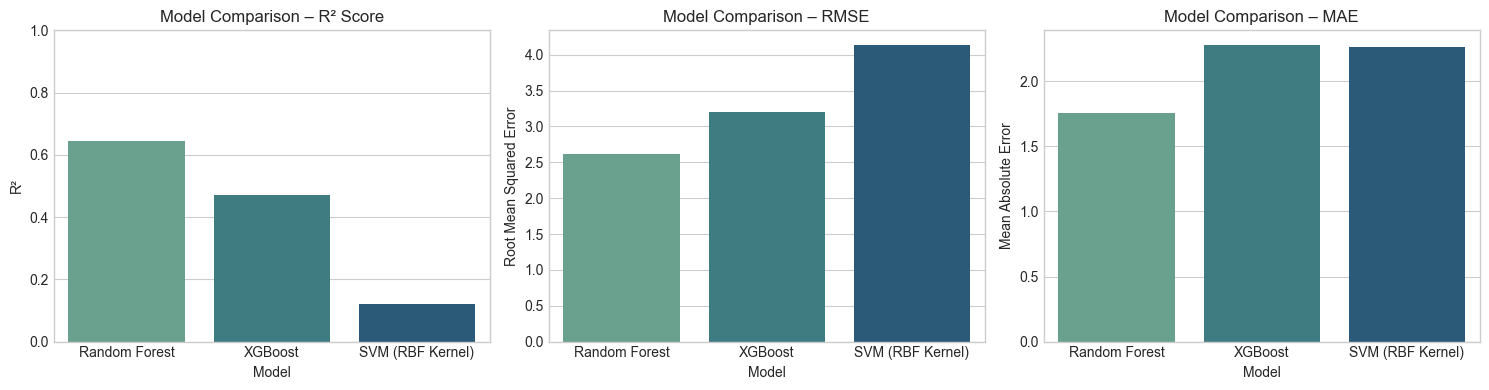

📊 Summary of Model Performance:

           Model  R² Score   RMSE    MAE
   Random Forest    0.6457 2.6222 1.7595
         XGBoost    0.4708 3.2050 2.2782
SVM (RBF Kernel)    0.1193 4.1346 2.2645


In [65]:
# ==============================================
# Part 4: Model Performance Visualization
# ==============================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# If you still have 'results_df' from Part 2 — use it directly.
# If not, you can re-create it quickly by re-running Part 2 above.

# Ensure results_df exists
assert "results_df" in globals(), "❌ Please re-run Part 2 first to generate 'results_df'."

# -----------------------------
# Plot settings
# -----------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# R² Score
sns.barplot(ax=axes[0], x="Model", y="R² Score", data=results_df, palette="crest")
axes[0].set_title("Model Comparison – R² Score")
axes[0].set_ylabel("R²")
axes[0].set_ylim(0, 1)

# RMSE
sns.barplot(ax=axes[1], x="Model", y="RMSE", data=results_df, palette="crest")
axes[1].set_title("Model Comparison – RMSE")
axes[1].set_ylabel("Root Mean Squared Error")

# MAE
sns.barplot(ax=axes[2], x="Model", y="MAE", data=results_df, palette="crest")
axes[2].set_title("Model Comparison – MAE")
axes[2].set_ylabel("Mean Absolute Error")

plt.tight_layout()
plt.show()

# -----------------------------
# Print numerical summary
# -----------------------------
print("📊 Summary of Model Performance:\n")
print(results_df.to_string(index=False))


In [66]:
# ==============================================
# Recreate model pipelines if not already loaded
# ==============================================
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

# SVM pipeline
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_pipe = Pipeline([("preprocess", preprocessor), ("model", svr_model)])

# Random Forest pipeline
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_pipe = Pipeline([("preprocess", preprocessor), ("model", rf_model)])

# XGBoost pipeline
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
xgb_pipe = Pipeline([("preprocess", preprocessor), ("model", xgb_model)])


In [67]:
# ==================================================
# Part 5: Predict Using the Trained Best Model
# ==================================================

import joblib
import pandas as pd

# 1️⃣ Load the trained pipeline
loaded_model = joblib.load("best_ev_model.pkl")
print("✅ Model loaded successfully!")

# 2️⃣ Create full input with all required columns
new_data = pd.DataFrame([{
    "building_id": 0,
    "building_name": "Test Building",
    "Population By FSA": 60000,
    "EV Population By FSA": 800,
    "num_units": 40,
    "floors": 5,
    "unit_sqft": 1200,
    "Average Household size per fsa": 3.0,
    "num_residents": 150,
    "ev_adoption_rate": 0.25,
    "postal_code": "M5E 1W5",
    "Parking": "Yes",
    "Notes": "N/A"
}])

# 3️⃣ Make the prediction
predicted_value = loaded_model.predict(new_data)

# 4️⃣ Display the result nicely
print("\n🔮 Prediction Summary:")
print("----------------------------")
print(f"📍 Input Postal Code: {new_data['postal_code'][0]}")
print(f"🏢 Building Name: {new_data['building_name'][0]}")
print(f"🚗 Predicted EV Owners per Building: {predicted_value[0]:.4f}")
print("----------------------------")


✅ Model loaded successfully!

🔮 Prediction Summary:
----------------------------
📍 Input Postal Code: M5E 1W5
🏢 Building Name: Test Building
🚗 Predicted EV Owners per Building: 34.9950
----------------------------


In [71]:
# ==================================================
# ✅ Predict EV Ownership for All Buildings
# ==================================================

import joblib
import pandas as pd

# 1️⃣ Load the trained model
loaded_model = joblib.load("best_ev_model.pkl")
print("✅ Model loaded successfully!")

# 2️⃣ Prepare full dataset (remove target column)
full_buildings = df.drop(columns=["Predicted EV Owners Per Building"])

# 3️⃣ Make predictions for all buildings
df["Predicted EV Owners Per Building"] = loaded_model.predict(full_buildings)

# 4️⃣ Display all results in a clean table
print("\n📊 EV Ownership Prediction Results (Full Dataset):")
pd.set_option('display.max_rows', None)  # show all rows
pd.set_option('display.float_format', '{:.3f}'.format)  # round to 3 decimals
display(df[["building_name", "postal_code", "Predicted EV Owners Per Building"]])

# 5️⃣ Save results to CSV
df.to_csv("predicted_ev_results_full.csv", index=False)
print("✅ All results saved as 'predicted_ev_results_full.csv'")


✅ Model loaded successfully!

📊 EV Ownership Prediction Results (Full Dataset):


,building_name,postal_code,Predicted EV Owners Per Building
0,25 The Esplanade,M5E 1W5,12.915
1,WaterWorks Condos,M5V 0P4,6.505
2,The Residences at The Well,M5V 0V4,8.520
3,One Bloor West,M4W 1A3,33.305
4,Leaside Towers,M4H 1L5,12.790
5,Massey Tower,M5B 0C1,10.380
6,The Park Mansion,L5R 3K4,25.405
7,Imperial Plaza,M4V 1N5,22.750
8,Keystone Condos,L5A 0B2,10.555
9,Harbourwalk Condos,L5E 1E9,34.855


✅ All results saved as 'predicted_ev_results_full.csv'
